## [1] Data Exploration

### PTB-XL QA

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io
import numpy as np
import wfdb
import random

In [ ]:
lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
hz = 500
start_time = 0
time = 5
start_length = int(start_time * hz)
sample_length = int(time * hz)
end_time = start_time + time
t = np.arange(start_time, end_time, 1 / hz)

def draw_ecg(ecg, lead=1):
    plt.plot(
        t,
        ecg[lead][start_length: start_length + sample_length],
        linewidth=2,
        color="k",
        alpha=1.0,
        label=lead_names[lead]
    )
    minimum = min(ecg[lead])
    maximum = max(ecg[lead])
    ylims_candidates = [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0 , 1.5, 2.0, 2.5]

    ylims = (
        max([x for x in ylims_candidates if x <= minimum]),
        min([x for x in ylims_candidates if x >= maximum]),
    )
    plt.vlines(np.arange(start_time, end_time, 0.2), ylims[0], ylims[1], colors="r", alpha=1.0)
    plt.vlines(np.arange(start_time, end_time, 0.04), ylims[0], ylims[1], colors="r", alpha=0.3)
    plt.hlines(np.arange(ylims[0], ylims[1], 0.5), start_time, end_time, colors="r", alpha=1.0)
    plt.hlines(np.arange(ylims[0], ylims[1], 0.1), start_time, end_time, colors="r", alpha=0.3)

    plt.xticks(np.arange(start_time, end_time + 1, 1.0))
    plt.margins(0.0)
    plt.show()


def draw_ecgs(ecgs, lead=1):
    for i, ecg in enumerate(ecgs):
        plt.rcParams["figure.figsize"] = (15, 1.5 * len(ecgs))
        plt.subplot(len(ecgs), 1, i + 1)
        draw_ecg(ecg[:,:2500], lead)


def visualize_sample(ecg_path, lead):
    ecgs = []
    ecg, th = wfdb.rdsamp(ecg_path)
    ecgs.append(ecg.T)
    draw_ecgs(ecgs, lead)        
    

In [ ]:
sample_data = {}
sample_data["ecg_paths"] = glob.glob(os.path.join("/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500", "*", "*.dat"))

sample_id = random.randint(0, 2000)
ecg_path = sample_data["ecg_paths"][sample_id].replace(".dat","")
ecg_name = ecg_path.split("/")[-1].split("_")[0]
print(ecg_name)
for lead in ["I", "II", "V2"]:
    lead = lead_names.index(lead)
    visualize_sample(ecg_path, lead)

In [ ]:
data = pd.read_csv("data/manifest/ptbxl_ecg_qa/valid_qa.tsv", sep='\t')
data.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def compute_lead_percentages(data, name):
    order = ['single-query', 'single-verify', 'single-choose']
    percentages = []
    for q_type in order:
        filtered = data[data['question_type'] == q_type]
        lead_count = filtered['question'].str.contains('lead', case=False, na=False).sum()
        percent = lead_count / len(filtered) * 100 if len(filtered) > 0 else 0
        percentages.append(percent)
    return percentages

# Load all sets
splits = {
    'Train': pd.read_csv("data/manifest/ptbxl_ecg_qa/train_qa.tsv", sep='\t'),
    'Validation': pd.read_csv("data/manifest/ptbxl_ecg_qa/valid_qa.tsv", sep='\t'),
    'Test': pd.read_csv("data/manifest/ptbxl_ecg_qa/test_qa.tsv", sep='\t')
}

# Compute all percentages
order = ['single-query', 'single-verify', 'single-choose']
results = {split: compute_lead_percentages(df, split) for split, df in splits.items()}

# Plot grouped bar chart
x = range(len(order))
bar_width = 0.25
colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
plt.figure(figsize=(10, 6))

for i, (split, percentages) in enumerate(results.items()):
    offset = [xi + bar_width * (i - 1) for xi in x]
    plt.bar(offset, percentages, width=bar_width, label=split)
    for j, val in enumerate(percentages):
        plt.text(offset[j], val + 2, f"{val:.1f}%", ha='center', fontsize=13)




plt.xticks(x, order, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Percentage', fontsize=16)
plt.ylim(0, 100)
plt.legend(ncol=3, loc='upper center', fontsize=16, frameon=True, fancybox=True)
plt.tight_layout()
plt.savefig("data.pdf", format='pdf', dpi=600, bbox_inches='tight')


In [ ]:
# Print average percentage per question type
averages = [sum(vals[i] for vals in results.values()) / len(results) for i in range(len(order))]
print("Average Lead-related Question Percentage per Type:")
for q_type, avg in zip(order, averages):
    print(f"{q_type}: {avg:.2f}%")


In [ ]:
data = pd.read_csv("data/manifest/ptbxl_ecg_qa/train_qa.tsv", sep='\t')
data.head()
extracted_info = data[data["ecg_id"] == int(ecg_name)]
extracted_info.head() # One ECG sample can have many question-answer pairs

In [ ]:
from wordcloud import WordCloud
# import lovelyplots
import matplotlib.pyplot as plt
# plt.style.use(['ipynb', 'use_mathtext'])

data['answer'] = data['answer'].apply(
    lambda x: x.replace(
        "bigeminal pattern (unknown origin, supraventricular, or ventricular)", 
        "bigeminal pattern (unknown origin; supraventricular; or ventricular)"
    ) if "bigeminal pattern (unknown origin, supraventricular, or ventricular)" in x else x
)

attributes = data['answer'].str.split(',')
attributes = attributes.explode().str.strip()
exploded_attributes = attributes.explode()

attribute_counts = exploded_attributes.value_counts()#.head(50)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(attribute_counts)

plt.figure(figsize=(18, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'All {len(attribute_counts)} Unique Attributes in Answers')
plt.show()


In [ ]:
single_verify_data = data[data['question_type'] == 'single-verify']

answer_counts = single_verify_data['answer'].value_counts()
print(answer_counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_counts.index, y=answer_counts.values, palette='viridis')
plt.xlabel('Unique Answer')
plt.ylabel('Count')
# plt.title("Distribution of Unique Answers for 'single-verify' Question Type")
plt.xticks(rotation=0)
plt.show()


In [ ]:
answer_class = pd.read_csv("data/raw/ptbxl/answers.csv")
answer_class = answer_class["class"].tolist()
print(len(answer_class))
unique_answers = set(attribute_counts.index)
unique_answers = {answer.replace(';', ',') if 'bigeminal pattern (unknown origin;' in answer else answer for answer in unique_answers}

assert set(unique_answers) == set(answer_class) # OKAY match!!! The paper said 103 labels, but it looks like "None" is considered as not others :)

In [ ]:
import matplotlib.pyplot as plt

question_types = ["S-Verify", "S-Choose", "S-Query"]
train_counts = [62554, 50015, 46737]
validation_counts = [10718, 9085, 11334]
test_counts = [13081, 9855, 18157]

bar_width = 0.2
r1 = range(len(question_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(r1, train_counts, width=bar_width, edgecolor='grey', label='Train')        
ax.bar(r2, validation_counts, width=bar_width, edgecolor='grey', label='Validation') 
ax.bar(r3, test_counts, width=bar_width, edgecolor='grey', label='Test')           

ax.set_xlabel('Question Type')
ax.set_ylabel('Number of Samples')
ax.set_title('PTBXL-QA Dataset Statistics for Different Question Types')
ax.set_xticks([r + bar_width for r in range(len(question_types))])
ax.set_xticklabels(question_types, fontsize=12)
ax.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

attribute_types = [
    "SCP code", "Noise", "Stage of infarction", "Extra systole",
    "Heart axis", "Numeric feature"
]
train_counts = [201183, 26192, 1233, 1777, 1780, 35374]
validation_counts = [47160, 6017, 304, 407, 395, 10380]
test_counts = [60869, 7460, 364, 493, 440, 12520]

bar_width = 0.2
r1 = np.arange(len(attribute_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(r1, train_counts, color='#F5D8DC', width=bar_width, edgecolor='grey', label='Train')
ax.bar(r2, validation_counts, color='#FDEADA', width=bar_width, edgecolor='grey', label='Validation')
ax.bar(r3, test_counts, color='#BBF5FD', width=bar_width, edgecolor='grey', label='Test')

# ax.set_xlabel('Attribute Type', fontsize=14)
ax.set_ylabel('Number of Samples', fontsize=14)
ax.set_title('PTB-XL Dataset Statistics for Different Attribute Types', fontsize=16)
ax.set_xticks([r + bar_width for r in range(len(attribute_types))])
ax.set_xticklabels(attribute_types, rotation=0, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
### DATA CHECK ###
data = pd.read_csv("data/manifest/ptbxl_ecg_qa/train_qa.tsv", sep='\t')

data["attribute"] = data["attribute"] + ", none"

def all_answers_in_attributes(row):
    answers = set(sorted([a.strip().lower() for a in row["answer"].split(",")]))
    attributes = set(sorted(a.strip().lower() for a in row["attribute"].split(",")))
    return answers.issubset(attributes)

single_choose_data = data[data["question_type"] == "single-choose"]
not_meeting_condition = single_choose_data[~single_choose_data.apply(all_answers_in_attributes, axis=1)]

count_included = len(single_choose_data) - len(not_meeting_condition)
total_single_choose = len(single_choose_data)

print("### DATA CHECK ###")
print(not_meeting_condition[["answer", "attribute"]].head())
print(f"Count included: {count_included}")
print(f"Total: {total_single_choose}")


In [ ]:
not_meeting_condition_range = not_meeting_condition[not_meeting_condition["question"].str.startswith("Which range")]
count_not_meeting_condition_range = len(not_meeting_condition_range)

print(f"Number of samples in not_meeting_condition where question starts with 'Which range': {count_not_meeting_condition_range}")  # 50015-49695


In [ ]:
not_meeting_condition_range = not_meeting_condition[not_meeting_condition["question"].str.startswith("Which leads")]
count_not_meeting_condition_range = len(not_meeting_condition_range)

print(f"Number of samples in not_meeting_condition where question starts with 'Which leads': {count_not_meeting_condition_range}")  # 50015-49695


In [ ]:
not_meeting_condition_range = not_meeting_condition[not_meeting_condition["question"].str.startswith("What numeric features")]
count_not_meeting_condition_range = len(not_meeting_condition_range)

print(f"Number of samples in not_meeting_condition where question starts with 'What numeric features': {count_not_meeting_condition_range}")   

In [ ]:
import pandas as pd

data = pd.read_csv("data/manifest/ptbxl_ecg_qa/train_qa.tsv", sep='\t')
filtered_rows = data[(data["answer"] == "none") & (data["question"].str.startswith("What leads", na=False))]
print(filtered_rows)


In [ ]:
# Full code with correctly aligned bar annotations and hidden x-axis label

fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    # Create the barplot
    bars = sns.barplot(x='Setting', y=metric, data=df, ax=ax, palette=palette)

    # Annotate each bar with its value above the bar using exact position
    for bar, val in zip(bars.patches, df[metric]):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.text(x, y + 0.002, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    # Dynamic y-limit for zoomed-in effect
    min_val = df[metric].min()
    proposed_val = df.loc[df['Setting'] == 'Proposed', metric].values[0]
    y_margin = (proposed_val - min_val) * 0.5
    ax.set_ylim(min_val - y_margin, proposed_val + y_margin)

    # Draw horizontal dashed line at minimum value
    ax.axhline(min_val, color='gray', linestyle='--', linewidth=1)

    # Draw red double-headed arrow and delta
    if proposed_val > min_val:
        x_pos = df[df['Setting'] == 'Proposed'].index[0]
        bar = bars.patches[x_pos]
        x_center = bar.get_x() + bar.get_width() / 2
        ax.annotate(
            '',
            xy=(x_center, proposed_val),
            xytext=(x_center, min_val),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2)
        )
        ax.text(x_center, (proposed_val + min_val)/2, f'Δ={proposed_val - min_val:.3f}', 
                color='red', va='center', ha='left', fontsize=10)

    ax.set_title(metric, fontsize=12)
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['Setting'], rotation=45, ha='right', fontsize=10)

    # Remove x-axis label
    ax.set_xlabel("")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("ablation.pdf", format='pdf', dpi=300, bbox_inches='tight')


### MIMIC IV ECG QA

In [ ]:
import os
import glob
import scipy.io

mimic_root = "/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/ptbxl/processed_qa_data"#"/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/processed_data"

In [ ]:
ecg_files = glob.glob(os.path.join(mimic_root, "*.mat"))
ecg_ids = [os.path.basename(path) for path in ecg_files]
print(len(ecg_files))

In [ ]:
ecg_ids = set(ecg_ids)

In [ ]:
ecg_sample = scipy.io.loadmat(ecg_files[0])
print(ecg_sample)


In [ ]:
import json 
import csv
from tqdm import tqdm

paraphrased = "data/raw/ptbxl/paraphrased"
saves = "data/manifest/ptbxl_ecg_qa"
data_sets = ["test", "valid", "train"]

for data_set in tqdm(data_sets):
    json_data_paths = glob.glob(os.path.join(paraphrased, data_set, "*.json"))
    tsv_file_path = os.path.join(saves, f"{data_set}_qa_new.tsv")
    
    with open(tsv_file_path, 'w', newline='', encoding='utf-8') as tsv_file:
        writer = csv.writer(tsv_file, delimiter='\t')
        writer.writerow(["ecg_id", "question_type", "question", "answer", "attribute", "attribute_type"])
        
        for json_data_path in json_data_paths:
            with open(json_data_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                
                for item in data:
                    ecg_id = item["ecg_id"][0]
                    if str(ecg_id)+".mat" not in ecg_ids:
                        print(f"Cannot find {ecg_id+'.mat'} in the processed data!!!")
                        continue
                    if str(ecg_id)+".mat" in ["46992044.mat", "44447291.mat", "47620441.mat"]:
                        continue
                    question_type = item["question_type"]
                    
                    if question_type not in ["single-verify", "single-choose", "single-query"]:
                        continue
                    
                    question = item["question"]
                    answer = ", ".join(item["answer"]).lower().strip()
                    attribute = ", ".join(item["attribute"]).lower().strip()
                    attribute_type = item["attribute_type"].lower().strip()
                    
                    writer.writerow([ecg_id, question_type, question, answer, attribute, attribute_type])

    print(f"Saved {data_set} data to {tsv_file_path}")

In [ ]:
import os
import random
from collections import defaultdict

def extract_balanced_random_subset(input_tsv, output_tsv, seed=42):
    random.seed(seed)
    
    with open(input_tsv, "r") as f:
        lines = f.readlines()
    
    # Assume the first line is the root directory path
    root_dir = lines[0].strip()
    data_lines = lines[1:]
    
    # Group data by question type and attribute type
    question_type_groups = defaultdict(lambda: defaultdict(list))
    for line in data_lines:
        parts = line.strip().split("\t")
        if len(parts) < 3:
            continue  # Skip malformed lines
        question_type = parts[1]  # Assume the second-to-last column is "question_type"
        attribute_type = parts[-1]  # Assume the last column is "attribute_type"
        question_type_groups[question_type][attribute_type].append(line)
    
    # Sample 10% from each attribute type within each question type
    sampled_lines = [root_dir + "\n"]
    for question_type, attribute_groups in question_type_groups.items():
        for attribute_type, group in attribute_groups.items():
            sample_size = max(1, round(len(group) * 0.1))  # Ensure at least one sample if 10% < 1
            sampled_lines.extend(random.sample(group, sample_size))
    
    # Save the sampled data to the output file
    with open(output_tsv, "w") as f:
        f.writelines(sampled_lines)

# Example usage
extract_balanced_random_subset(
    "data/manifest/ptbxl_ecg_qa/test_qa_new.tsv", 
    "data/manifest/ptbxl_ecg_qa/test_qa_10.tsv"
)


In [ ]:
# extract_balanced_random_subset("data/manifest/ptbxl_ecg_qa/valid_qa_new.tsv", "data/manifest/ptbxl_ecg_qa/valid_qa_10.tsv")
# extract_balanced_random_subset("data/manifest/ptbxl_ecg_qa/train_qa_new.tsv", "data/manifest/ptbxl_ecg_qa/train_qa_10.tsv")


In [ ]:
import pandas as pd 
import numpy as np 

data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')
data.head()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')
question_type_counts = train_data["question_type"].value_counts()
question_types = question_type_counts.index.tolist()
train_counts = question_type_counts.values

val_data = pd.read_csv("data/manifest/mimic_ecg_qa/valid_qa.tsv", sep='\t')
question_type_counts = val_data["question_type"].value_counts()
question_types = question_type_counts.index.tolist()
validation_counts = question_type_counts.values

test_data = pd.read_csv("data/manifest/mimic_ecg_qa/test_qa.tsv", sep='\t')
question_type_counts = test_data["question_type"].value_counts()
question_types = question_type_counts.index.tolist()
test_counts = question_type_counts.values

bar_width = 0.2
r1 = range(len(question_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(r1, train_counts, color='#F5D8DC', width=bar_width, edgecolor='grey', label='Train')        
ax.bar(r2, validation_counts, color='#FDEADA', width=bar_width, edgecolor='grey', label='Validation') 
ax.bar(r3, test_counts, color='#BBF5FD', width=bar_width, edgecolor='grey', label='Test')           

ax.set_xlabel('Question Type')
ax.set_ylabel('Number of Samples')
ax.set_title('MIMIC-QA Dataset Statistics for Different Question Types')
ax.set_xticks([r + bar_width for r in range(len(question_types))])
ax.set_xticklabels(question_types, fontsize=12, rotation=0)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd 
import numpy as np 

data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')
data.head()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')
filtered_data = data[ (data["question_type"] == "single-verify")]

answer_counts = filtered_data["answer"].value_counts()
answer_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Distribution of Unique Answers ('not sure', 'single-verify')")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.show()


In [ ]:
none_count = (data["answer"] == "none").sum()
print(f"Number of answers equal to 'none': {none_count}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')

none_count = (data["answer"] == "none").sum()
not_none_count = len(data) - none_count

counts = pd.Series({"none": none_count, "not none": not_none_count})

counts.plot(kind="bar", color="skyblue", figsize=(8, 5))
plt.title("Distribution of 'none' and not 'none' Answers")
plt.xlabel("Answer Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa_with_new_context.tsv", sep='\t')

In [ ]:
def max_word_counts(data):
    max_question_words = data['context'].str.split().str.len().max()
    max_answer_words = data['answer'].str.split().str.len().max()
    max_total_words = data.apply(lambda row: len(row['context'].split(" ")) + len(row['answer'].split(" ")), axis=1).max()
    return max_question_words, max_answer_words, max_total_words

max_q_words, max_a_words, max_total_words = max_word_counts(data)
print("Max number of words in 'context':", max_q_words)
print("Max number of words in 'answer':", max_a_words)
print("Max total words in a row:", max_total_words)


In [ ]:
import seaborn as sns

data['question_length'] = data['context'].str.split().str.len()
data['answer_length'] = data['answer'].str.split().str.len()

# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(data['question_length'], kde=True, color='blue', label='Question Length', bins=30)
sns.histplot(data['answer_length'], kde=True, color='green', label='Answer Length', bins=30)

# Customize plot
plt.title('Word Length Distribution of Questions and Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:

answers_gt_60 = data[data['context'].str.split(" ").str.len() > 21]

print(len(answers_gt_60))
print("\nRows where 'answer' has more than 60 words:")
print(answers_gt_60["ecg_id"])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("data/manifest/mimic_ecg_qa/train_qa.tsv", sep='\t')

# Define the function
def plot_question_type_lead_percentage(data):
    question_types = data['question_type'].unique()
    percentages = []

    for q_type in question_types:
        filtered = data[data['question_type'] == q_type]
        lead_count = filtered['question'].str.contains('lead', case=False, na=False).sum()
        percentages.append(lead_count / len(filtered) * 100)

    # Plotting
    plt.bar(question_types, percentages, color=['blue', 'green', 'orange'])
    plt.ylabel('Percentage of Questions Containing "lead"')
    plt.xlabel('Question Type')
    plt.title('Percentage of "lead" Questions by Question Type')
    plt.ylim(0, 100)
    for i, percent in enumerate(percentages):
        plt.text(i, percent + 1, f"{percent:.1f}%", ha='center', fontsize=10)
    plt.show()

# Call the function
plot_question_type_lead_percentage(data)


## [2] ECG Encoder

In [ ]:
import h5py
import numpy as np
from scipy.signal import resample

path_to_hdf5 = '/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/ecg_tracings.hdf5'

with h5py.File(path_to_hdf5, 'r') as hdf:
    tracings = hdf['tracings'][:] 
    print("Original shape:", tracings.shape)  # (827, 4096, 12)
    original_samples = tracings.shape[1] 
    resampled_samples = int(original_samples * (500 / 400)) 
    resampled_tracings = np.array([resample(tracing, resampled_samples, axis=0).T for tracing in tracings])    
    truncated_tracings = resampled_tracings[:, :, :5000]
    print("Truncated shape:", truncated_tracings.shape)  # (827, 5000, 12)
    
    

In [ ]:
path_to_hdf5 = '/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/ecg_tracings.hdf5'

with h5py.File(path_to_hdf5, 'r') as hdf:
    tracings = hdf['tracings'][:] 
    print("Original shape:", tracings.shape)  # (827, 4096, 12)
    original_samples = tracings.shape[1] 
    resampled_samples = int(original_samples * (500 / 400)) 
    resampled_tracings = np.array([resample(tracing, resampled_samples, axis=0).T for tracing in tracings])    
    truncated_tracings = resampled_tracings[:, :, :5000]
    print("Truncated shape:", truncated_tracings.shape)  # (827, 5000, 12)

In [ ]:
import matplotlib.pyplot as plt
leads = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg = truncated_tracings[np.random.randint(len(truncated_tracings))]
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    ax = axs[i // 4, i % 4]
    ax.plot(ecg[i, :])
    ax.set_title(leads[i])
plt.show()

In [ ]:
import json

all_labels = '1AVB,RBBB,LBBB,SB,AFIB,ST'.split(",")

with open("configs/SCPMapper.json", 'r') as file:
    converting_tool = json.load(file)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

def compute_roc_auc(y_true, y_pred, model_name):
    roc_auc = []
    for i in range(y_true.shape[1]): 
        auc = roc_auc_score(y_true[:, i], y_pred[:, i], average='macro', multi_class='ovo')
        roc_auc.append(auc)
    print(f"ROC AUC scores for {model_name}: {np.mean(roc_auc)}")
    return roc_auc

In [ ]:
csv_path = '/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/gold_standard.csv'
df = pd.read_csv(csv_path)
diagnoses_test = df.values 

y_true = pd.read_csv('/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/gold_standard.csv').values
y_cardio = pd.read_csv('/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/cardiology_residents.csv').values
y_emerg = pd.read_csv('/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/emergency_residents.csv').values
y_student = pd.read_csv('/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/medical_students.csv').values
y_neuralnet = pd.read_csv('/common/home/users/h/hm.pham.2023/workspace/ecg_foundation_model/data/downstream/code-test/data/annotations/dnn.csv', usecols=range(1, 7)).values

model_names = ["Fully Trained DNN", "Cardiology Residents", "Emergency Residents", "Medical Students"]
model_predictions = [y_neuralnet, y_cardio, y_emerg, y_student]

for model_name, y_pred in zip(model_names, model_predictions):
    compute_roc_auc(y_true, y_pred, model_name)

In [ ]:
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import json
from transformers import T5TokenizerFast
from models.ecg_encoder.cmelt import M3AEModel
from types import SimpleNamespace


def load_encoders(checkpoint_path=""):
    with open('configs/ECGEncoder.json', 'r') as json_file:
        cfg = json.load(json_file)

    cfg = SimpleNamespace(**cfg['model'])
    model = M3AEModel(cfg)
    checkpoint = torch.load(checkpoint_path)
    if "ecg_encoder.mask_emb" in checkpoint["model"].keys():
        del checkpoint["model"]["ecg_encoder.mask_emb"]

    model.load_state_dict(checkpoint["model"], strict=True)
    model.eval()
    return model, model.ecg_encoder, model.language_encoder, model.unimodal_ecg_pooler, model.unimodal_language_pooler, model.multi_modal_ecg_proj, model.multi_modal_language_proj, model.class_embedding


def extract_language_features(model, texts, pooler=None, proj=None):
    model_name = "google/flan-t5-base"
    tokenizer = T5TokenizerFast.from_pretrained( 
            model_name, do_lower_case="uncased" in model_name
        ) 
    features_dict = {}
    
    for text in tqdm(texts):
        encoded_input = tokenizer(text, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**encoded_input)[0]
            outputs = proj(outputs)
            if pooler is None:
                max_pooled_features, _ = torch.max(outputs, dim=1)  
            else:
                max_pooled_features = pooler(outputs)
            
            features_dict[text] = max_pooled_features.numpy().squeeze(0)

    print("Successfully Extracted Language Features !!!")
    
    return features_dict
    
    
def extract_ecg_features(model, ecgs, pooler=None, proj=None, class_embedding=None, batch_size=100):
    features = []
    num_ecgs = len(ecgs)
    padding_mask = torch.zeros(batch_size, 12, 5000, dtype=torch.bool)
    
    for start_idx in tqdm(range(0, num_ecgs, batch_size)):
        end_idx = min(start_idx + batch_size, num_ecgs)
        ecg_batch = torch.tensor(ecgs[start_idx:end_idx], dtype=torch.float32)
        
        with torch.no_grad():

            uni_modal_ecg_feats, ecg_padding_mask = (
                model.get_embeddings(ecg_batch, padding_mask=None)
            )
            
            cls_emb = class_embedding.repeat((len(uni_modal_ecg_feats), 1, 1))
            uni_modal_ecg_feats = torch.cat([cls_emb, uni_modal_ecg_feats], dim=1)
            uni_modal_ecg_feats = model.get_output(uni_modal_ecg_feats, ecg_padding_mask)
            out = proj(uni_modal_ecg_feats)
            ecg_features = pooler(out)
            
            features.append(ecg_features.numpy())
            
    print("Successfully Extract Features !!!")
    
    return np.concatenate(features, axis=0)


def zero_shot(checkpoint_path, model_name=None):
    print(f"Evaluating {model_name} ...")
    model, ecg_model, language_model, unimodal_ecg_pooler, unimodal_language_pooler, multi_modal_ecg_proj, multi_modal_language_proj, class_embedding = load_encoders(checkpoint_path)
    print(ecg_model)
    potential_labels = [converting_tool[i].lower() for i in all_labels]
    potential_language_features_dict = extract_language_features(language_model, potential_labels, unimodal_language_pooler, multi_modal_language_proj)
    ecg_features = extract_ecg_features(ecg_model, truncated_tracings, unimodal_ecg_pooler, multi_modal_ecg_proj, class_embedding, batch_size=100)   

    all_similarities = []
    all_actual_labels = []
    
    for i, ecg_feature in tqdm(enumerate(ecg_features)):
        ecg_feature = torch.tensor(ecg_feature)

        similarities = []
        for _, potential_feature in potential_language_features_dict.items():
            potential_feature = torch.tensor(potential_feature).reshape(1, -1)
            ecg_feature = ecg_feature.reshape(1, -1)
            sim_score = ecg_feature @ potential_feature.T
            similarities.append(sim_score[0][0].item())
        
        all_similarities.append(similarities)

    all_similarities = np.array(all_similarities)
    
    all_actual_labels = np.array(diagnoses_test)

    n_classes = 6
    
    aucs = []
    for i in range(n_classes):
        auc = roc_auc_score(all_actual_labels[:, i], all_similarities[:, i], average='macro', multi_class='ovo')
        aucs.append(auc)
        print(f"AUC at class {all_labels[i]}: ", auc)
    
    average_auc = np.mean(aucs)
    print(f"Zero-shot classification AUC: {average_auc:.4f}")
    
    return average_auc

In [ ]:
average_auc = zero_shot("ckpts/Add_12Enc.pt", "best") 

In [ ]:
from models.ecg_encoder.ecg_encoder import get_model
ecg_encoder = get_model("ckpts/best.pt")

/tmp/ipykernel_1552244/503435356.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='ROC AUC', y='Model', data=df, palette=palette)


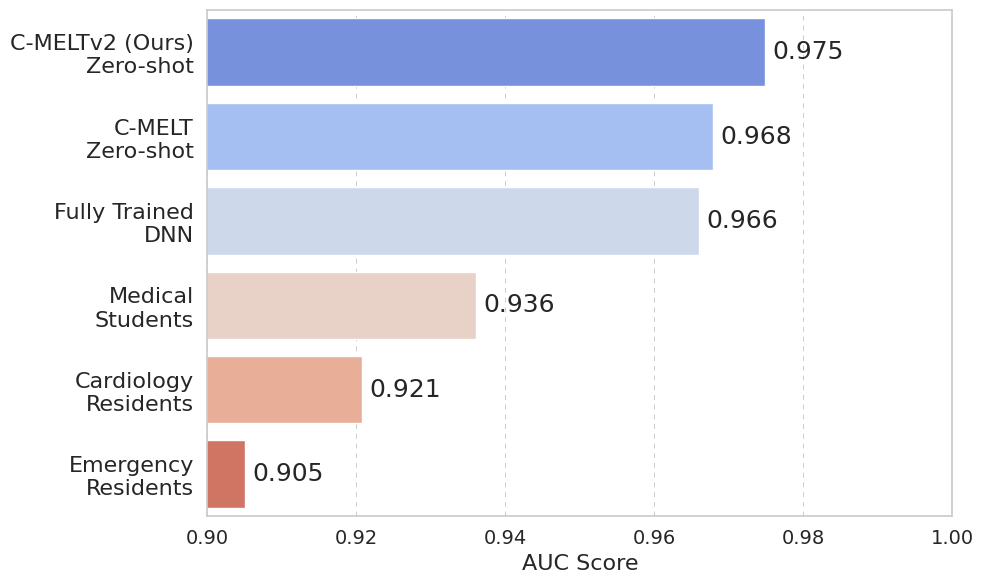

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
mpl.rcParams['ps.fonttype'] = 42

# Data with line breaks to save space
models = [
    'Fully Trained\nDNN',
    'Cardiology\nResidents',
    'Emergency\nResidents',
    'Medical\nStudents',
    'C-MELT\nZero-shot',
    'C-MELTv2 (Ours)\nZero-shot'
]

scores = [
    0.9659994995269608,
    0.9207702067848343,
    0.9051381516474534,
    0.9361089491663092,
    0.9679,
    0.9748
]

# Create DataFrame
df = pd.DataFrame({'Model': models, 'ROC AUC': scores})
df = df.sort_values(by='ROC AUC', ascending=False)

# Plotting

sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", len(df))
# palette = sns.color_palette("pastel")  # soft and light colors

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='ROC AUC', y='Model', data=df, palette=palette)

# Add score labels
for i, (score, name) in enumerate(zip(df['ROC AUC'], df['Model'])):
    plt.text(score + 0.001, i, f"{score:.3f}", va='center', fontsize=18)

# Axis formatting
plt.xlabel('AUC Score', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.7, dashes=(5, 5))

plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel("")

plt.xlim(0.9, 1.0)
plt.tight_layout()

plt.savefig("test15.pdf", format='pdf', dpi=600, bbox_inches='tight')


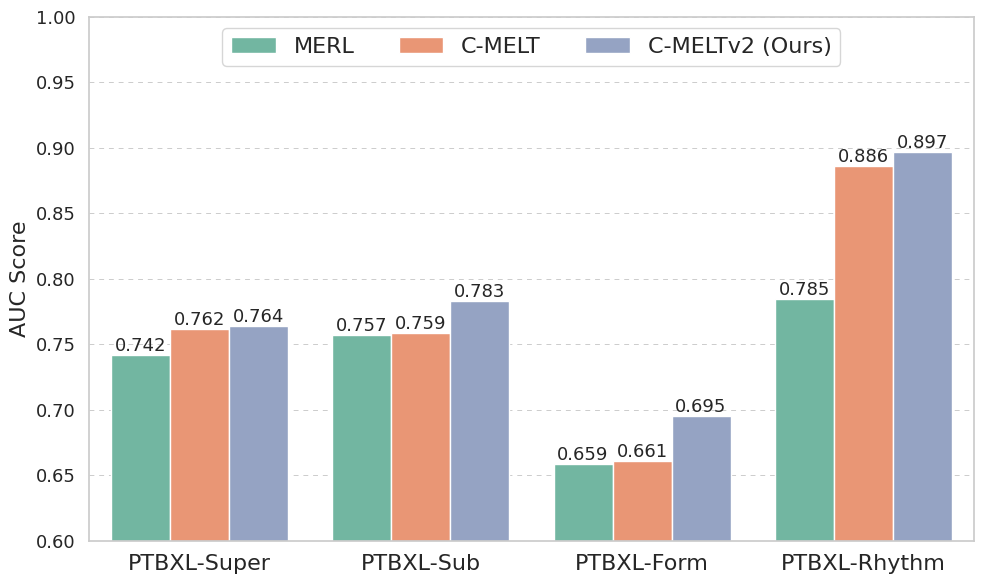

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
data = {
    'Dataset': ['PTBXL-Super', 'PTBXL-Sub', 'PTBXL-Form', 'PTBXL-Rhythm'] * 3,
    'AUC': [
        74.2, 75.7, 65.9, 78.5,   # MERL
        76.2, 75.9, 66.1, 88.6,   # C-MELT
        76.4, 78.3, 69.5, 89.7    # C-MELT12
    ],
    'Method': ['MERL'] * 4 + ['C-MELT'] * 4 + ['C-MELTv2 (Ours)'] * 4
}

df = pd.DataFrame(data)
df['AUC'] /= 100  # Convert to [0, 1]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=df, x='Dataset', y='AUC', hue='Method', palette='Set2')

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.3f}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=13)

plt.grid(axis='y', linestyle='--', linewidth=0.7, dashes=(5, 5))
plt.xticks(fontsize=16)
plt.xlabel("")
plt.ylabel('AUC Score', fontsize=16)
plt.ylim(0.6, 1.0)
plt.yticks(fontsize=13)

# Set legend as a single row above the plot
plt.legend(ncol=3, loc='upper center', fontsize=16, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("ptbxl.pdf", format='pdf', dpi=600, bbox_inches='tight')


## [3] Mapper

In [ ]:
from models.prefix_mappers import TransformerMapper

In [ ]:
ecg_projection_layer = TransformerMapper(
    dim_clip=768,
    dim_embedding=2048,
    prefix_length=12,
    clip_length=12,
    num_heads=4,
    num_layers=2
)

In [ ]:
import torch
import torch.nn as nn 

x = torch.randn(2,1,768)
print(ecg_projection_layer(x).shape)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Parameters:", count_parameters(ecg_projection_layer))
